In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json

# Trex calibration



<figure>
<img src="setup.png" style="width:40%">
<figcaption align = "center"><b>Fig.1 - Physical setup</b>
</figcaption></figure>

In [3]:
%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

The following table shows the hardware components.


|     |                                 |
|-----|---------------------------------|
| CPU | Intel Xeon(R) Gold 6238R @ 2.2 GHz|
| NIC | ConnectX-5 QSFP28 MCX516A-CCAT  |

The following table documents the considered software and firmware versions for the different components.

|||
|----|---|
|OS| Centos 7.9|
|Trex|v3.02|
|OFED|5.7-1|

The following are the boot parameters used to configure the traffic generator.

```
isolcpus=1-27,29-55 iommu=pt intel_iommu=on default_hugepagesz=2M hugepagesz=2M hugepages=50000 hugepagesz=1G hugepages=4 nohz_full=1-27,29-55 tsc=reliable irqaffinity=0 rcu_nocbs=1-27,29-55 rcu_nocbs_poll idle=poll intel_idle.max_cstate=0 rsc=reliable mce=ignore_ce audit=0 nmi_watchdog=0 skew_tick=1 nosoftlookup rd.auto=1
```

We have disabled Turbo mode on the CPU, and while doing the test the CPU is running as follows. The following is the output of [power.py](https://github.com/intel/CommsPowerManagement/blob/master/power.py).


```
==== ================================ == ================
                         P-STATE INFO      UNCORE INFO 
Core    Max    Min    Now    Governor     Max      Min
==== ====== ====== ====== =========== ======= ========
   1   2200   1000   2199   powersave    2400     1200
   2   2200   1000   2200   powersave    2400     1200
   3   2200   1000   2200   powersave    2400     1200
   4   2200   1000   2200   powersave    2400     1200
   5   2200   1000   2200   powersave    2400     1200
   6   2200   1000   2200   powersave    2400     1200
   7   2200   1000   2200   powersave    2400     1200
   8   2200   1000   2200   powersave    2400     1200
   9   2200   1000   2200   powersave    2400     1200
  10   2200   1000   2199   powersave    2400     1200
  11   2200   1000   2200   powersave    2400     1200
  12   2200   1000   2200   powersave    2400     1200
  13   2200   1000   2200   powersave    2400     1200
  14   2200   1000   2199   powersave    2400     1200
  15   2200   1000   2200   powersave    2400     1200
  16   2200   1000   2200   powersave    2400     1200
  17   2200   1000   2200   powersave    2400     1200
```


## Results

In [4]:
output_dir = "../output/"

measurements = list()

for direc, sub_direc, files in os.walk(output_dir):
    
    if files == []:
        continue
            
    for file in files:
        experiment, label, flows, repeat = direc.replace(output_dir, '').split('/')

        if 'ndr' in file:
            t = pd.read_json(direc + '/' + files[0]).to_dict()
            
            measurements.append(
                {
                'cpu_util': t['results']['cpu_util'],
                'rate_tx_bps': t['results']['rate_tx_bps'],
                'rate_rx_bps': t['results']['rate_rx_bps'],
                'rx_pps': t['results']['rx_pps'],
                'tx_pps': t['results']['tx_pps'],
                'total_rx_L1': t['results']['total_rx_L1'],
                'total_tx_L1': t['results']['total_tx_L1'],
                'total_cores': int(t['config']['total_cores']),
                'bw_per_core': t['results']['bw_per_core'],
                'Hyperthreading': 'enabled' if 'ht' in direc else 'Disabled',
                'flows': int(flows),
                'repeat': int(repeat),
                'experiment': experiment,
                }
            )

        elif 'trex' in file:
            with open(direc + '/' + files[0], "r") as f:
                contents = f.read().replace("\n", "").replace("\'", "\"")
                try:
                    t = ast.literal_eval(contents)
                except SyntaxError:
                    print(direc + '/' + files[0])
                    continue

            measurements.append(
                {
                'cpu_util': t['global']['cpu_util'],
                'rx_pps': t['total']['rx_pps'],
                'tx_pps': t['total']['tx_pps'],
                'total_rx_L1': t['total']['rx_bps_L1'],
                'total_tx_L1': t['total']['tx_bps_L1'],
                'total_cores': 24,
                'bw_per_core': t['global']['bw_per_core'],
                'flows': int(flows),
                'repeat': int(repeat),
                'experiment': experiment,
                }
            )

measurements_df = pd.DataFrame(measurements)

### CPU architecture

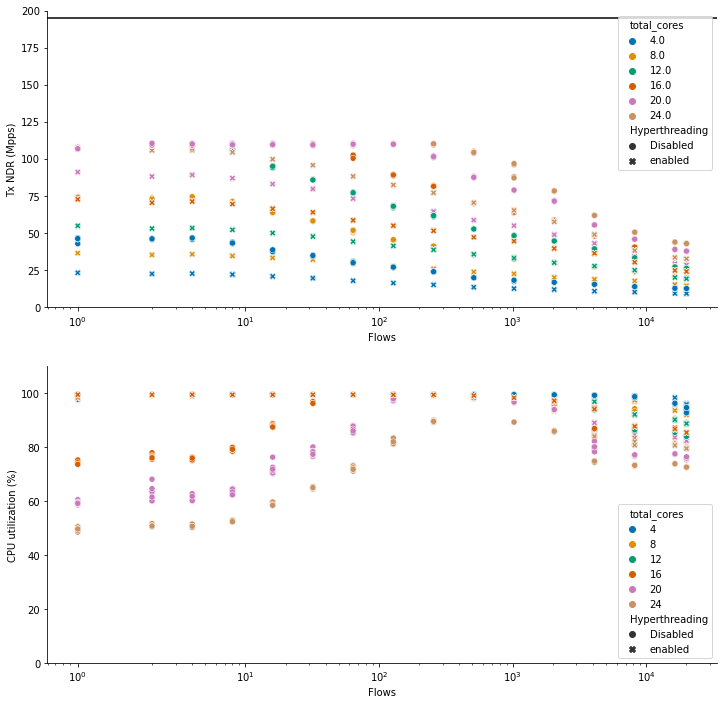

In [19]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

core_df = measurements_df[measurements_df['experiment'] == 'ncores']

ax1.set_xscale('symlog')
sns.scatterplot(
    data = core_df,
    x = 'flows',
    y = measurements_df['tx_pps']/1000000,
    hue = 'total_cores',
    style = 'Hyperthreading',
    ax = ax1,
    palette = 'colorblind',
)

ax1.set(
    ylim = [0, 200],
    ylabel = 'Tx NDR (Mpps)',
    xlabel = 'Flows'

)

ax1.axhline(100000000000/(64*8)/1000000, color = 'black', )
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
ax1.xaxis.set_minor_locator(locmin)

ax2.set_xscale('symlog')
sns.scatterplot(
    data = core_df,
    x = 'flows',
    y = 'cpu_util',
    hue = 'total_cores',
    style = 'Hyperthreading',
    #join=False,
    ax = ax2,
    palette = 'colorblind',
)

locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
ax2.xaxis.set_minor_locator(locmin)

ax2.set(
    ylim = [0, 110],
    ylabel = 'CPU utilization (%)',
    xlabel = 'Flows'
       )
sns.despine()

For the 16 core case, the number of membufs needed to be increased (24570 -> 49140)

### Target rate

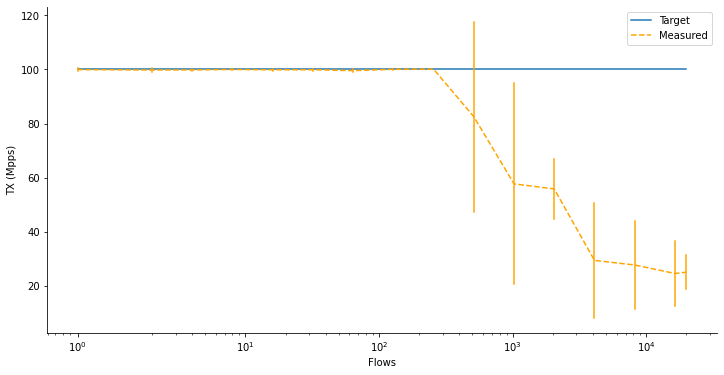

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

core_df = measurements_df[measurements_df['experiment'] == 'rate-100mpps-flow']
flows = core_df['flows'].values
tx = core_df['tx_pps'].values

ideal = pd.Series({i: 100000000 for i in flows})

ax1.set_xscale('symlog')

p1 = sns.lineplot(
    #data = pd.Series(T),
    x = ideal.index,
    y = ideal.values/1000000,
    #join=False,
    ax = ax1,
    label = 'Target',
    #linestyles = "--",
)

p2 = sns.lineplot( 
    x = flows,
    y = tx/1000000,
    err_style = 'bars',
    ax = ax1,
    label = 'Measured',
    #join = False,
    color = "orange",
    ci = "sd",
    linestyle = '--',
)

locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
ax1.xaxis.set_minor_locator(locmin)

ax1.set(
    ylabel = 'TX (Mpps)',
    xlabel = 'Flows'
)

leg = ax1.legend(labels=["Target", "Measured"])
leg.legendHandles[1].set_color('orange')

# ax1.axhline(100000000000/((72))/1000000, color = 'black', )

sns.despine()